In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Control warnings
import warnings; warnings.simplefilter('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch
import anndata
from tqdm import tqdm
from umap import UMAP
from openTSNE import TSNE
import scanpy as sc 
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
import scvi
print('You are using scvi-tools version:',scvi.__version__)


You are using scvi-tools version: 0.13.0


In [2]:
de=pd.read_csv('sample_DE_results_ASEL_taylor2020.csv', index_col=0)
de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
gene_id,,,,,,,,,,,,,,,,,,,,
WBGene00017353,1.0000,0.0000,18.420681,0.000303,3.407846e-06,0.0,0.25,7.050107,7.268034,1.193114,-2.748963,10.259166,0.323077,0.001650,0.241026,0.001650,3.106004,0.036508,True,ADA
WBGene00009723,1.0000,0.0000,18.420681,0.000716,1.455193e-06,0.0,0.25,9.402954,9.609663,2.021290,-2.271848,14.772098,1.184616,0.001650,0.425641,0.001650,12.753178,0.015641,True,ADA
WBGene00008208,1.0000,0.0000,18.420681,0.000205,7.105370e-07,0.0,0.25,9.217788,9.452880,1.655195,-2.354724,13.118017,0.276923,0.000000,0.179487,0.000000,4.072764,0.000000,True,ADA
WBGene00007776,1.0000,0.0000,18.420681,0.000253,2.573572e-06,0.0,0.25,9.063905,9.410938,2.327135,-4.627872,14.477261,0.117949,0.001650,0.112821,0.001650,1.333601,0.031552,True,ADA
WBGene00003591,1.0000,0.0000,18.420681,0.005264,1.503229e-05,0.0,0.25,9.096885,9.359121,1.851299,-2.885214,13.570353,4.184619,0.004950,0.815385,0.004950,48.345900,0.126958,True,ADA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00016313,0.7036,0.2964,0.864500,0.000014,1.363255e-05,0.0,0.25,-0.007345,-0.080864,0.674260,-1.987994,3.267508,0.020513,0.000000,0.020513,0.000000,0.127773,0.000000,False,hmc
WBGene00004505,0.7028,0.2972,0.860667,0.000079,6.631264e-05,0.0,0.25,0.214199,0.155497,0.721613,-2.022303,3.174768,0.061538,0.098039,0.046154,0.078431,0.469635,1.000700,False,hmc
WBGene00015074,0.7004,0.2996,0.849203,0.000034,3.356215e-05,0.0,0.25,0.107797,0.111808,0.662548,-2.248716,2.447339,0.082051,0.000000,0.076923,0.000000,0.951133,0.000000,False,hmc


In [3]:
# downloads a file that maps gene names to gene id and puts that in a dataframe
# the genemaps is used to add the gene names
!wget -nc https://raw.githubusercontent.com/Munfred/worm-markers/master/worm_gene_name_id.csv
genemaps = pd.read_csv('./worm_gene_name_id.csv', index_col=1)
name2id=genemaps.set_index('gene_name')
name2id['gene_id']=genemaps.index

File ‘worm_gene_name_id.csv’ already there; not retrieving.



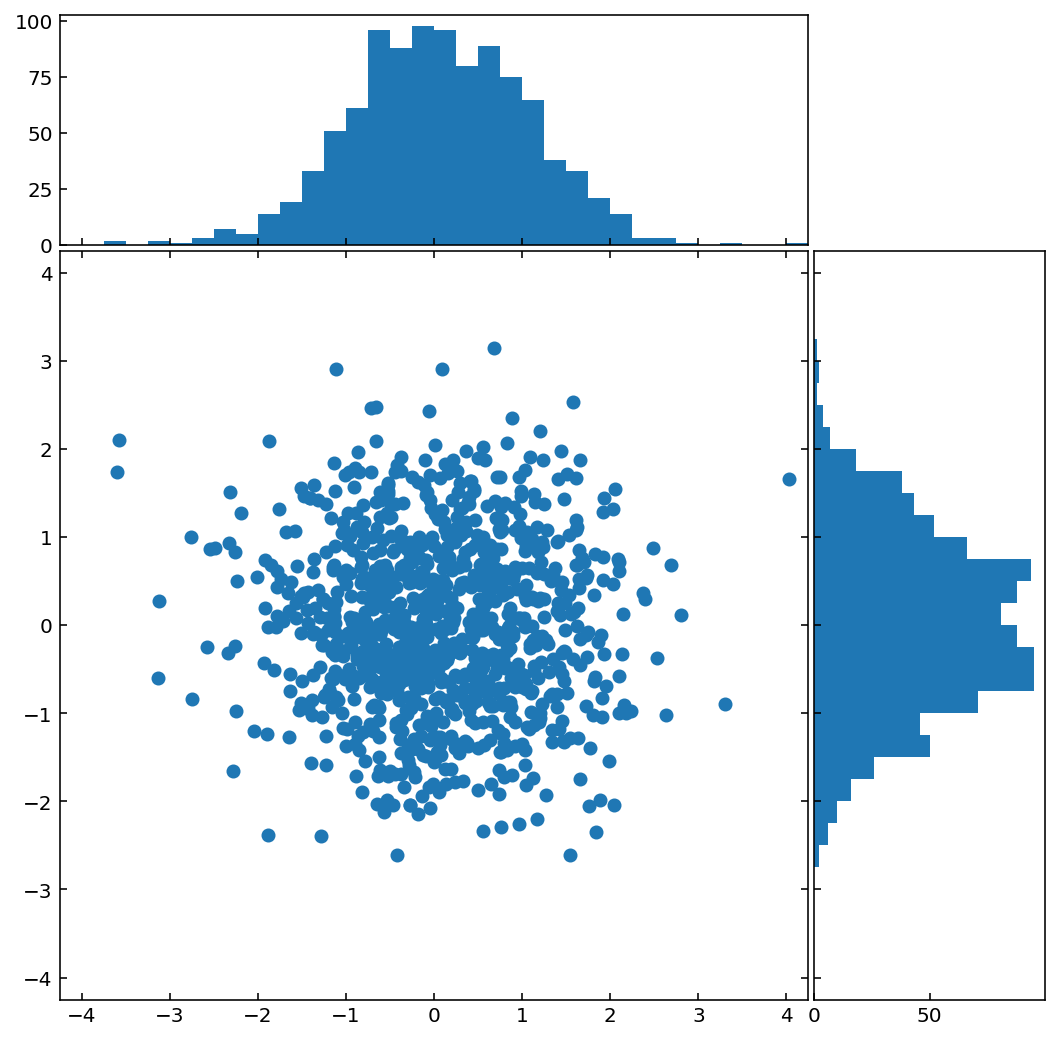

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()